In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')

### 4.5 Automatic Feature Selection
- 특성 차원이 높은 데이터 셋에 대해 유용한 특성만 선택하고 나머지는 무시하는 통계적 기법
  - Univariate Statistics (일변량 통계)
  - Model-based Selection (모델 기반 선택)
  - Iterative Selection (반복적 선택)
- 위 방법 모두 지도학습 방법
  - 최적의 특성을 찾기 위해서 타깃 정보이 필요
- 훈련 데이터와 테스트 데이터를 나눈 다음 훈련 데이터에 대해서만 위 기법 적용하여 특성 선택해야 함.

#### 4.5.1 Univariate statistics (일변량 통계)
- ANOVA (Analysis of Variance, 분산분석)
  - 개개의 특성과 타깃 사이에 중요한 통계적 관계가 있는지 분석하여 관련성이 깊은 특성만 선별
  - 각 특성이 독립적으로 평가됨
  - 계산 속도 빠름
  - 분석을 위한 모델 구성 필요 없음
  - 특성 선택 이후 적용하려는 모델에 상관없이 사용가능

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
print("Shape of cancer data: {}".format(cancer.data.shape))

Shape of cancer data: (569, 30)


In [3]:
import numpy as np

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
print("Shape of noise: {}".format(noise.shape))

Shape of noise: (569, 50)


In [4]:
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])
print("Shape of X_w_noise: {}".format(X_w_noise.shape))

Shape of X_w_noise: (569, 80)


- ANOVA를 내장한 scikit-learn 일변량 분석 모듈
  - feature_selection.SelectKBest
    - 가장 연관성이 높은 k개의 특성 선택 
  - feature_selection.SelectPercentile
    - 가장 연관성이 높은 특성을 지정된 비율 만큼 선택

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


- get_support()
  - 어떠한 특성이 선택되었는지를 확인해줌

In [7]:
import matplotlib.pyplot as plt

mask = select.get_support()
print(mask)

# 30보다 작거나 같은 인덱스
print([x for x in np.where(mask == False)[0].tolist() if x < 30])

# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]
[9, 11, 18, 19]


([], <a list of 0 Text yticklabel objects>)

In [8]:
mask.reshape(1, -1)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False,  True, False,  True,
        False, False,  True, False, False, False, False,  True, False,
        False,  True, False, False,  True, False,  True, False, False,
        False, False, False, False,  True, False,  True, False, False,
        False, False,  True, False,  True, False, False, False, False,
         True,  True, False,  True, False, False, False, False]])

- 전체 80개의 특성을 이용했을 때와 선택된 40개의 특성을 이용했을 때의 LogisticRegression 모델 성능 비교

In [9]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression()

lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


#### 4.5.2 Model-based Feature Selection (모델 기반 특성 선택)
- 지도학습 모델을 사용하여 특성의 중요도를 평가하여 중요 특성 선별
- 특성 선택에 사용했던 지도학습 모델과 최종적으로 사용할 모델과 동일할 필요는 없음.
- 한번에 모든 특성을 고려하여 선별하므로 Univariate statistics (일변량 통계) 방식보다 더 성능이 좋음
- feature_selection.SelectFromModel(model, threshold)
  - 주어진 model을 활용하여 모델을 생성하고 threshold에 지정된 임계치보다 큰 모든 특성을 선택함
  - 아래 예제는 절반의 특성을 선별하도록 threshold="median"을 인자로 넣음

In [10]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median"
)

In [11]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False  True False
 False False False False  True False False  True False  True  True False
 False False  True False False  True  True False False False False False
 False  True False False False False False False False  True False False
 False  True False False False False False False]
[11, 14]


([], <a list of 0 Text yticklabel objects>)

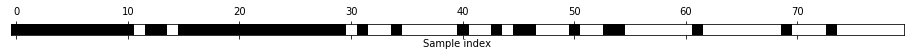

In [12]:
mask = select.get_support()
print(mask)

# 30보다 작거나 같은 인덱스
print([x for x in np.where(mask == False)[0].tolist() if x < 30])

# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [13]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


#### 4.5.3 Iterative feature selection (반복적 특성 선택)
- 첫번째 방법
  - 특성을 선택하지 않은 상태에서 어떤 종료 조건에 도달할 때까지 새로운 특성을 하나씩 선택하는 방법
- 두번째 방법
  - 모든 특성을 선택한 상태에서 어떤 종료 조건에 도달할 때까지 특성을 하나씩 제거하는 방법
  - 재귀적 특성 제거(Recursive Feature Elimination, RFE)
    - feature_selection.RFE(model, n_features_to_select)
      - 1) 전체 특성을 활용하여 주어진 model을 만듦.
      - 2) 특성 중요도가 가장 낮은 특성부터 제거
      - 3) 제거한 특성을 제외하고 다시 1)로 이동하여 model을 새롭게 만듦
      - 특성의 개수가 n_features_to_select로 남을때 까지 위와 같은 과정 반복 

In [14]:
from sklearn.feature_selection import RFE
select = RFE(
    RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=40
)

select.fit(X_train, y_train)
X_train_rfe = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_rfe.shape: {}".format(X_train_rfe.shape))

X_train.shape: (284, 80)
X_train_rfe.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False False False
 False False False False False False False False False False False  True
  True False  True False False  True  True False False False  True False
 False False False False False  True False  True False False False False
 False  True False False False  True False False]
[16]


([], <a list of 0 Text yticklabel objects>)

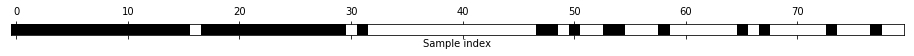

In [15]:
# visualize the selected features:
mask = select.get_support()
print(mask)

# 30보다 작거나 같은 인덱스
print([x for x in np.where(mask == False)[0].tolist() if x < 30])

plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [16]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [17]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951
